<a href="https://colab.research.google.com/github/xKazimir/ZNEUS_Project2/blob/main/ZNEUS_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARIES

In [24]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
import matplotlib.pyplot as plt


# LOAD DATASET

In [ ]:
#dataset download - uncomment for first run
#!wget "https://www.ais.uni-bonn.de/deep_learning/LabelMe-12-50k.tar.gz"

--2025-11-21 16:07:02--  https://www.ais.uni-bonn.de/deep_learning/LabelMe-12-50k.tar.gz
Resolving www.ais.uni-bonn.de (www.ais.uni-bonn.de)... 131.220.7.4
Connecting to www.ais.uni-bonn.de (www.ais.uni-bonn.de)|131.220.7.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 483863381 (461M) [application/x-gzip]
Saving to: ‘LabelMe-12-50k.tar.gz’

LabelMe-12-50k.tar. 100%[===================>] 461.45M  36.0MB/s    in 14s     

2025-11-21 16:07:16 (34.2 MB/s) - ‘LabelMe-12-50k.tar.gz’ saved [483863381/483863381]



In [ ]:
#unzip - uncomment for first run
#!tar -xzf LabelMe-12-50k.tar.gz

In [13]:
#classes
classes_path = "/content/classes.txt"

classes = []
with open(classes_path, "r") as f:
    for line in f:
        line = line.strip()
        if line:
            classes.append(line)

print("Classes:", classes)
print("N classes:", len(classes))


Classes: ['person', 'car', 'building', 'window', 'tree', 'sign', 'door', 'bookshelf', 'chair', 'table', 'keyboard', 'head']
N classes: 12


In [14]:
#train annotation
train_ann_path = "/content/train/annotation.txt"

train_labels = {}

with open(train_ann_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        img_id = parts[0]
        vals = []
        for v in parts[1:]:
            val = float(v)
            vals.append(val)
        train_labels[img_id] = torch.tensor(vals)
print("Train annotations:", len(train_labels))


Train annotations: 40000


In [15]:
#test annotations
test_ann_path = "/content/test/annotation.txt"

test_labels = {}

with open(test_ann_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        img_id = parts[0]
        vals = []
        for v in parts[1:]:
            val = float(v)
            vals.append(val)
        test_labels[img_id] = torch.tensor(vals)
print("Test annotations:", len(test_labels))


Test annotations: 10000


In [17]:
#load file paths for train
train_root = "/content/train"

train_image_paths = [] # file paths
train_image_targets = [] # tensors(labels)

for root, _, files in os.walk(train_root):
    for name in files:
        if name.lower().endswith((".jpg")):
            img_id = os.path.splitext(name)[0]
            path = os.path.join(root, name)
            train_image_paths.append(path)
            train_image_targets.append(train_labels[img_id])


In [18]:
#load file paths for test
test_root = "/content/test"

test_image_paths = [] # file paths
test_image_targets = [] # tensors(labels)

for root, _, files in os.walk(test_root):
    for name in files:
        if name.lower().endswith((".jpg")):
            img_id = os.path.splitext(name)[0]
            path = os.path.join(root, name)
            test_image_paths.append(path)
            test_image_targets.append(test_labels[img_id])


In [20]:
# image transform (resize and tensor)
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def load_image_as_tensor(path):
    img = Image.open(path).convert("RGB")
    return img_transform(img)

# test
#img_tensor = load_image_as_tensor(train_image_paths[0])
#lbl_tensor = train_image_targets[0]
#print("Image tensor shape:", img_tensor.shape)  # [3, 224, 224]
#print("Label tensor:", lbl_tensor)


In [21]:
#returns batches of imgs as tensors :)
def batch_generator(image_paths, image_targets, batch_size):
    n = len(image_paths)
    indices = torch.arange(n)
    #indices = torch.randperm(n)  # random order each epoch

    batch_imgs = []
    batch_labels = []

    for idx in indices:
        path = image_paths[idx]
        label = image_targets[idx]

        img_tensor = load_image_as_tensor(path)
        batch_imgs.append(img_tensor)
        batch_labels.append(label)

        if len(batch_imgs) == batch_size:
            images_batch = torch.stack(batch_imgs, dim=0)
            labels_batch = torch.stack(batch_labels, dim=0)
            yield images_batch, labels_batch
            batch_imgs = []
            batch_labels = []

    # last batch
    if batch_imgs:
        images_batch = torch.stack(batch_imgs, dim=0)
        labels_batch = torch.stack(batch_labels, dim=0)
        yield images_batch, labels_batch


In [23]:
train_gen = batch_generator(train_image_paths, train_image_targets, batch_size=32)
images_batch, labels_batch = next(train_gen)

print("Batch images shape:", images_batch.shape)
print("Batch labels shape:", labels_batch.shape)
print("First label vector:", labels_batch[0])
print("Active classes for first sample:",
      [c for c, v in zip(classes, labels_batch[0]) if v == 1])


Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32, 12])
First label vector: tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])
Active classes for first sample: []


# EDA

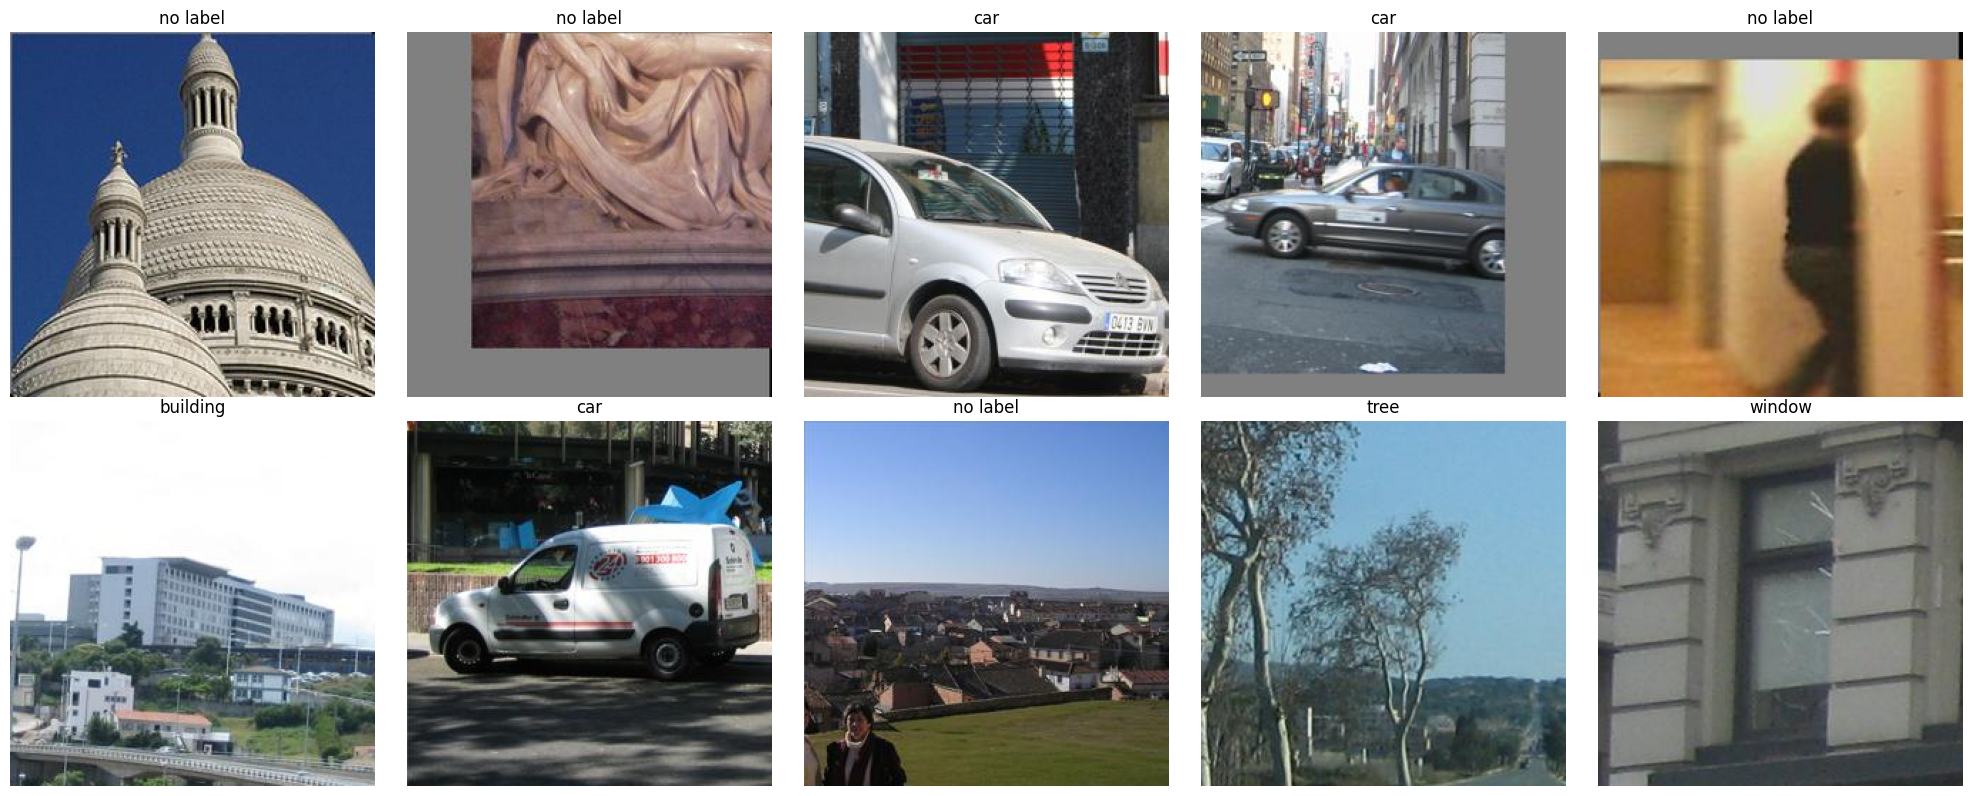

In [40]:
#even in the last cell of LOAD DATASET we can see that no label is set to 1, lets have a look at that
#print random 10 pictures
# this is written for <=10 pictures, if you want more just change the plt.figure line
num_to_show = 10

#random indexes
indices = random.sample(range(len(train_image_paths)), num_to_show)

plt.figure(figsize=(20, 8))

for i, idx in enumerate(indices):
    path = train_image_paths[idx]
    label_tensor = train_image_targets[idx]

    # load normal img
    img = Image.open(path).convert("RGB")

    # labels set to 1
    active_classes = [c for c, v in zip(classes, label_tensor) if v == 1]

    #small img 2x5 in matplotlib with corresponding position
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(img)
    ax.axis("off") #no need for pixel counts...
    title = ", ".join(active_classes) if active_classes else "no label"
    ax.set_title(title)

plt.tight_layout()
plt.show()
#after running this a couple of times we can see that